In [221]:
import numpy as np
import cv2
import open3d as o3d

import matplotlib.pyplot as plt

In [222]:
tag_size = 4.0
tag_size_half = tag_size/2

fx = 610.32366943
fy = 610.5026245
cx = 313.3859558
cy = 237.2507269
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]], dtype=np.float64)
objPoints = np.array([[-tag_size_half, -tag_size_half, 0],
                      [tag_size_half, -tag_size_half, 0],
                      [tag_size_half, tag_size_half, 0],
                      [-tag_size_half, tag_size_half, 0]], dtype=np.float64)

In [223]:
def show_image(imgPoints, size=(480,640,3)):
    image = np.zeros(size)+1.0
    point_size = 10
    point_color = (0,0,1.0)
    thickness = -1
    for i in range(imgPoints.shape[0]):
        point = imgPoints[i,:]
        cv2.circle(image, (int(point[0]), int(point[1])), point_size, point_color, thickness)
        
    pts = imgPoints.reshape((-1,1,2)).astype(int)
    #cv2.polylines(image,[pts],True,(0,1.0,0),1)
    return image

In [224]:
def test_image_pts(objPoints, imgPoints, cameraMatrix, distCoeffs = None):
    retval_1,rvec_1,tvec_1  = cv2.solvePnP(objPoints, imgPoints, cameraMatrix, distCoeffs)
    R, _ = cv2.Rodrigues(rvec_1)
    pose_1 = np.eye(4)
    pose_1[0:3,0:3] = R
    pose_1[0:3, 3] = tvec_1.reshape(3)

    #plt.imshow(show_image(imgPoints))
    print("position of the camera :", tvec_1.transpose())
    return pose_1, tvec_1

In [225]:
def draw_two_set_points(imgPoints_1, imgPoints_2, size=(480,640,3)):
    image = np.zeros(size)+1.0
    point_size = 10
    point_color = (0,0,1.0)
    thickness = -1
    for i in range(imgPoints_1.shape[0]):
        point = imgPoints_1[i,:]
        cv2.circle(image, (int(point[0]), int(point[1])), point_size, point_color, thickness)
        
    point_color = (0,1.0,0)    
    for i in range(imgPoints_2.shape[0]):
        point = imgPoints_2[i,:]
        cv2.circle(image, (int(point[0]), int(point[1])), point_size, point_color, thickness)
        
    return image

In [226]:
imgPoints_1 = np.array([[500, 370], [200, 370], [200, 69], [500, 71]], dtype=np.float64)
pose_1, tvec_1 = test_image_pts(objPoints, imgPoints_1, K)

position of the camera : [[ 0.49467361 -0.23082055  8.1349726 ]]


In [227]:
offset = 3
imgPoints_2 = np.array([[500, 370+offset], [200, 370+offset], [200, 69-offset], [500, 71-offset]], dtype=np.float64)
pose_2, tvec_2 = test_image_pts(objPoints, imgPoints_2, K)

position of the camera : [[ 0.49624892 -0.22655426  8.05089544]]


the distance of two cameras with 3 pixels difference is 0.08420006238708715


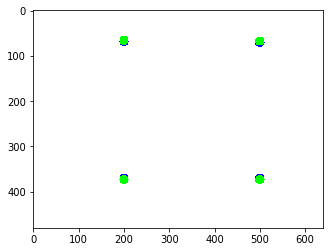

In [228]:
plt.imshow(draw_two_set_points(imgPoints_1, imgPoints_2))
distance = tvec_2 - tvec_1
print("the distance of two cameras with", offset, "pixels difference is", np.linalg.norm(distance))

## Show the error

In [245]:
def draw_camera_o3d(P_c_w, color = [1, 0, 0]):
    P_w_c = np.linalg.inv(P_c_w)
    w = 0.2
    h = w * 0.75
    z = w * 0.6
    points = [
        [0, 0, 0, 1],
        [w, h, z, 1],
        [w, -h, z, 1],
        [-w, -h, z, 1],
        [-w, h, z, 1]
    ]
    points = np.asarray(points).transpose()
    points_camera = np.dot(P_w_c, points)
    points = []
    for i in range(points_camera.shape[1]):
        points.append([points_camera[0,i], points_camera[1,i], points_camera[2,i]])
    
    lines = [
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 2],
        [4, 3],
        [4, 1],
        [2, 3]
    ]
    colors = [color for i in range(len(lines))]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    return line_set

In [230]:
objPoints_other_corner = np.array([[-tag_size_half, -tag_size_half, 0],
                      [tag_size_half, -tag_size_half, 0],
                      [tag_size_half, tag_size_half, 0],
                      [-tag_size_half, tag_size_half, 0]], dtype=np.float64).transpose()

R, _ = cv2.Rodrigues(np.array([0,3.14/2,0]))
objPoints_other_corner = np.dot(R, objPoints_other_corner)
# transform to the camera coordinate system
tvec_inv = -np.dot(pose_1[0:3,0:3].transpose(), tvec_1)
objPoints_other_corner = np.dot(pose_1[0:3,0:3].transpose(), objPoints_other_corner) + tvec_inv

# translation
trans = np.array([-8.0,0,0.0]).reshape([3,1])
objPoints_other_corner = objPoints_other_corner + trans

In [249]:
points = o3d.geometry.PointCloud()
points.points = o3d.utility.Vector3dVector(objPoints)

axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
thing_to_show = [axis_pcd, points]
thing_to_show.append(draw_camera_o3d(pose_1, [0,0,1.0]))
thing_to_show.append(draw_camera_o3d(pose_2, [1.0,0,0]))

o3d.visualization.draw_geometries(thing_to_show)

![image](images/error_show.png)

## Extreme cases

position of the camera : [[ 0.59418075 -0.22017815  8.00676856]]
the distance of two cameras with 10 pixels difference is 0.16263827033821568


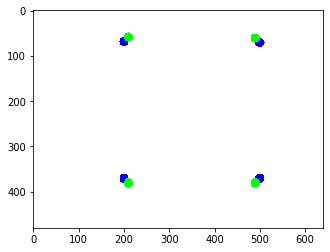

In [243]:
offset = 10
imgPoints_3 = np.array([[500-offset, 370+offset], [200+offset, 370+offset], [200+offset, 69-offset], [500-offset, 71-offset]], dtype=np.float64)
pose_3, tvec_3 = test_image_pts(objPoints, imgPoints_3, K)

plt.imshow(draw_two_set_points(imgPoints_1, imgPoints_3))
distance = tvec_3 - tvec_1
print("the distance of two cameras with", offset, "pixels difference is", np.linalg.norm(distance))

In [250]:
points = o3d.geometry.PointCloud()
color = [(255,0,0) for i in range(objPoints.shape[0])]
points.colors = o3d.utility.Vector3dVector(color)
points.points = o3d.utility.Vector3dVector(objPoints)

axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
thing_to_show = [axis_pcd, points]
thing_to_show.append(draw_camera_o3d(pose_1, [0,0,1.0]))
thing_to_show.append(draw_camera_o3d(pose_3, [1.0,0,0]))

o3d.visualization.draw_geometries(thing_to_show)

![image](images/error_show_2.png)

In [247]:
points_2 = o3d.geometry.PointCloud()
color_2 = [(255,0,0) for i in range(objPoints_other_corner.shape[1])]
points_2.points = o3d.utility.Vector3dVector(objPoints_other_corner.transpose())
points_2.colors = o3d.utility.Vector3dVector(color_2)

point2_camera_gt = np.dot(pose_1[0:3,0:3].transpose(), objPoints_other_corner) + tvec_inv
point2_w = np.dot(pose_3[0:3,0:3], point2_camera_gt) + tvec_3

point1_camera_gt = np.dot(K, objPoints.transpose()) + tvec_inv
point1_w = np.dot(pose_3[0:3,0:3], point1_camera_gt) + tvec_3

points_4 = o3d.geometry.PointCloud()
color_4 = [(0,0,255) for i in range(point2_w.shape[1])]
points_4.points = o3d.utility.Vector3dVector(point2_w.transpose())
points_4.colors = o3d.utility.Vector3dVector(color_4)

axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
thing_to_show = [axis_pcd, points, points_2, points_4]
thing_to_show.append(draw_camera_o3d(pose_1, [1, 0, 0]))
thing_to_show.append(draw_camera_o3d(pose_3, [0, 0, 1]))

o3d.visualization.draw_geometries(thing_to_show)

![image](images/error_show_3.png)